In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [20]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'image_audio'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"

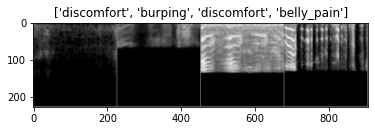

In [21]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [23]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [24]:
model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) 

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/mia/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 17.4MB/s]


In [25]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 1.6014 Acc: 0.1923
val Loss: 1.5923 Acc: 0.3000

Epoch 1/99
----------
train Loss: 1.6093 Acc: 0.2308
val Loss: 1.5960 Acc: 0.3000

Epoch 2/99
----------
train Loss: 1.5857 Acc: 0.2692
val Loss: 1.5910 Acc: 0.3500

Epoch 3/99
----------
train Loss: 1.5572 Acc: 0.3077
val Loss: 1.6025 Acc: 0.3000

Epoch 4/99
----------
train Loss: 1.5918 Acc: 0.3077
val Loss: 1.5472 Acc: 0.3500

Epoch 5/99
----------
train Loss: 1.5478 Acc: 0.3462
val Loss: 1.5791 Acc: 0.3500

Epoch 6/99
----------
train Loss: 1.5611 Acc: 0.3077
val Loss: 1.5492 Acc: 0.3500

Epoch 7/99
----------
train Loss: 1.5821 Acc: 0.3077
val Loss: 1.5544 Acc: 0.3500

Epoch 8/99
----------
train Loss: 1.5557 Acc: 0.3077
val Loss: 1.5483 Acc: 0.3500

Epoch 9/99
----------
train Loss: 1.5273 Acc: 0.3077
val Loss: 1.5442 Acc: 0.3500

Epoch 10/99
----------
train Loss: 1.5458 Acc: 0.3462
val Loss: 1.5393 Acc: 0.3500

Epoch 11/99
----------
train Loss: 1.5498 Acc: 0.3077
val Loss: 1.5432 Acc: 0.3500

Ep

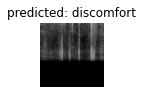

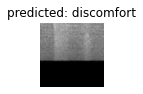

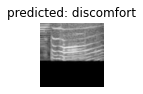

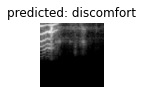

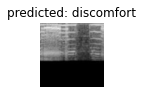

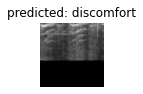

In [26]:
visualize_model(model_ft)

In [27]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [28]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.7633 Acc: 0.2692
val Loss: 1.5487 Acc: 0.4000

Epoch 1/24
----------
train Loss: 1.7707 Acc: 0.2692
val Loss: 1.6167 Acc: 0.3500

Epoch 2/24
----------
train Loss: 1.6956 Acc: 0.2308
val Loss: 1.6948 Acc: 0.2000

Epoch 3/24
----------
train Loss: 1.7753 Acc: 0.1538
val Loss: 1.5122 Acc: 0.4000

Epoch 4/24
----------
train Loss: 1.6592 Acc: 0.2308
val Loss: 1.7061 Acc: 0.3000

Epoch 5/24
----------
train Loss: 1.5586 Acc: 0.2308
val Loss: 1.5441 Acc: 0.4000

Epoch 6/24
----------
train Loss: 1.6249 Acc: 0.2692
val Loss: 1.5681 Acc: 0.4500

Epoch 7/24
----------
train Loss: 1.4444 Acc: 0.3846
val Loss: 1.5802 Acc: 0.4000

Epoch 8/24
----------
train Loss: 1.3860 Acc: 0.3462
val Loss: 1.5758 Acc: 0.4000

Epoch 9/24
----------
train Loss: 1.5000 Acc: 0.3846
val Loss: 1.5732 Acc: 0.4000

Epoch 10/24
----------
train Loss: 1.4307 Acc: 0.4615
val Loss: 1.5594 Acc: 0.4000

Epoch 11/24
----------
train Loss: 1.4347 Acc: 0.3077
val Loss: 1.5737 Acc: 0.4000

Ep

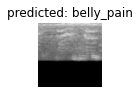

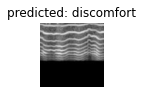

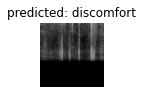

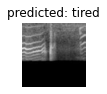

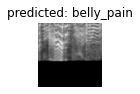

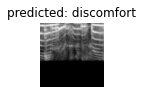

In [29]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [30]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [31]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'